## Importing the libraries

In [1]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf 
import absl
import os
import functools

2023-02-19 08:02:09.332195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-19 08:02:10.121179: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-19 08:02:14.741958: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-1

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


## Some environment variables / configurations you can play with to improve performanc

```
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"]= "4"
os.environ["TF_ONEDNN_ASSUME_FROZEN_WEIGHTS"]="1"
os.environ["TF_ENABLE_MKL_NATIVE_FORMAT"]="1"
os.environ["TF_ONEDNN_USE_SYSTEM_ALLOCATOR"]="1" # increased time
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(4)"""
```

You can run `!lscpu` to get the information you need to set this. Furthermore, you can go to the link and read more about what these parameters do. In my exerience, these did not contribute significantly to reducing the time.

Source: https://www.intel.com/content/www/us/en/developer/articles/technical/maximize-tensorflow-performance-on-cpu-considerations-and-recommendations-for-inference.html

## Creating a more TF-friendly `StableDiffusion` version based on `keras_cv`

The provided `StableDiffusion` model in `keras_cv` cannot be saved in `SavedModel` type due to the way it is setup (e.g. usage of `predict_on_batch` prevents graph building). Another limitation is that, the tokenizer used in this library is not TensorFlow compatible, therefore needs to be bourght outside for the model to be successfully saved. Furthermore, certain pathways in the code can be further optimized by using Tensorflow specific functions, e.g. `tf.while_loop`, and by combining internal model calls. Here we introduce such changes and create a new model called `StableDiffusionNoTokenizer`.

In [3]:
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel

from keras_cv.models.stable_diffusion.decoder import Decoder
from keras_cv.models.stable_diffusion.stable_diffusion import StableDiffusion
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

import tensorflow as tf 

MAX_PROMPT_LENGTH = 77

class StableDiffusionNoTokenizer(StableDiffusion):

    def __init__(self, encoded_text_length=None, **kwargs):
      super().__init__(**kwargs)
      gpus = tf.config.list_physical_devices('GPU')
      self.encoded_text_length = encoded_text_length
      print("Running TF on the GPU: ", (len(gpus)>0))
      
    @tf.function
    def generate_image(
        self,
        encoded_text,
        negative_prompt_tokens=None,
        batch_size=1,
        num_steps=50,
        unconditional_guidance_scale=7.5,
        diffusion_noise=None,
        seed=None,
    ):
        """Generates an image based on encoded text.
        The encoding passed to this method should be derived from
        `StableDiffusion.encode_text`.
        Args:
            encoded_text: Tensor of shape (`batch_size`, 77, 768), or a Tensor
            of shape (77, 768). When the batch axis is omitted, the same encoded
            text will be used to produce every generated image.
            batch_size: number of images to generate. Default: 1.
            negative_prompt: a string containing information to negatively guide
            the image generation (e.g. by removing or altering certain aspects
            of the generated image).
                Default: None.
            num_steps: number of diffusion steps (controls image quality).
                Default: 50.
            unconditional_guidance_scale: float controling how closely the image
                should adhere to the prompt. Larger values result in more
                closely adhering to the prompt, but will make the image noisier.
                Default: 7.5.
            diffusion_noise: Tensor of shape (`batch_size`, img_height // 8,
                img_width // 8, 4), or a Tensor of shape (img_height // 8,
                img_width // 8, 4). Optional custom noise to seed the diffusion
                process. When the batch axis is omitted, the same noise will be
                used to seed diffusion for every generated image.
            seed: integer which is used to seed the random generation of
                diffusion noise, only to be specified if `diffusion_noise` is
                None.
        Example:
        ```python
        from keras_cv.models import StableDiffusion
        batch_size = 8
        model = StableDiffusion(img_height=512, img_width=512, jit_compile=True)
        e_tacos = model.encode_text("Tacos at dawn")
        e_watermelons = model.encode_text("Watermelons at dusk")
        e_interpolated = tf.linspace(e_tacos, e_watermelons, batch_size)
        images = model.generate_image(e_interpolated, batch_size=batch_size)
        ```
        """
        
        print("generate_image")
        # Scalars are not properly handled by tf serving and can have extra dims, 
        # so here we squeeze it just in case
        num_steps = tf.squeeze(num_steps)
        batch_size = tf.squeeze(batch_size)

        if diffusion_noise is not None and seed is not None:
            raise ValueError(
                "`diffusion_noise` and `seed` should not both be passed to "
                "`generate_image`. `seed` is only used to generate diffusion "
                "noise when it's not already user-specified."
            )

        context = self._expand_tensor(encoded_text, batch_size)

        if negative_prompt_tokens is None:
            unconditional_context = tf.repeat(
                self._get_unconditional_context(), batch_size, axis=0
            )
        else:
            unconditional_context = self.text_encoder([negative_prompt_tokens, self._get_pos_ids()], training=False)
            unconditional_context = self._expand_tensor(
                unconditional_context, batch_size
            )
        
        if diffusion_noise is not None:
            diffusion_noise = tf.squeeze(diffusion_noise)
            if diffusion_noise.shape.rank == 3:
                diffusion_noise = tf.repeat(
                    tf.expand_dims(diffusion_noise, axis=0), batch_size, axis=0
                )
            latent = diffusion_noise
        else:
            latent = self._get_initial_diffusion_noise(batch_size, seed)
        
        if self.encoded_text_length is not None:
            context = context[:, :self.encoded_text_length, :]
            unconditional_context = unconditional_context[:, :self.encoded_text_length, :]
            
        latent = self.diffusion_reverse_loop(
            latent,
            context=context, 
            unconditional_context=unconditional_context, 
            batch_size=batch_size, 
            unconditional_guidance_scale=unconditional_guidance_scale,
            num_steps=num_steps,
        )

        # Decoding stage
        decoded = self.decoder(latent, training=False)
        decoded = ((decoded + 1) / 2) * 255
        return tf.cast(tf.clip_by_value(decoded, 0, 255), "uint8")
    
    @tf.function
    def diffusion_reverse_loop(self, latent, context, unconditional_context, batch_size, unconditional_guidance_scale, num_steps):
        
      print("tracing diffusion_reverse_loop_v2")
      index = num_steps -1
      cond = tf.math.greater(index, -1)
      timesteps = tf.range(1, 1000, 1000 // num_steps)
      alphas, alphas_prev = self._get_initial_alphas(timesteps)
      iter_partial_fn = functools.partial(
          self._diffusion_reverse_iter, 
          timesteps=timesteps, 
          alphas=alphas, 
          alphas_prev=alphas_prev, 
          context=context, 
          unconditional_context=unconditional_context, 
          batch_size=batch_size, 
          unconditional_guidance_scale=unconditional_guidance_scale, 
          num_steps=num_steps
      )

      latent, index = tf.while_loop(cond=lambda _, i: tf.math.greater(i, -1), body=iter_partial_fn, loop_vars=[latent, index])
    
      return latent 

    @tf.function
    def _diffusion_reverse_iter(self, latent_prev, index, timesteps,  alphas, alphas_prev, context, unconditional_context, batch_size, unconditional_guidance_scale, num_steps):

      print("tracing diffusion_reverse_iter")
      #tf.print("Running the step index =", index, " timestep =", timesteps[index])
      
      t_emb = self._get_timestep_embedding(timesteps[index], batch_size)
      
      combined_latent = self.diffusion_model(
                [
                    tf.concat([latent_prev, latent_prev],axis=0), 
                    tf.concat([t_emb, t_emb], axis=0), 
                    tf.concat([context, unconditional_context], axis=0)
                ], training=False
            )
      latent, unconditional_latent = tf.split(combined_latent, 2, axis=0)
      latent = unconditional_latent + unconditional_guidance_scale * (
            latent - unconditional_latent
      )
      a_t, a_prev = alphas[index], alphas_prev[index]
      pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
      latent = latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
      index -= 1

      return latent, index
      

    @tf.function
    def _get_initial_alphas(self, timesteps):
      alphas = tf.map_fn(lambda x: tf.gather(_ALPHAS_CUMPROD, x), timesteps, fn_output_signature=tf.float32)
      alphas_prev = tf.concat([[1.0], alphas[:-1]], axis=0)

      return alphas, alphas_prev

    @tf.function
    def _get_unconditional_context(self):
        unconditional_tokens = tf.convert_to_tensor(
            [_UNCONDITIONAL_TOKENS], dtype=tf.int32
        )
        unconditional_context = self.text_encoder(
            [unconditional_tokens, self._get_pos_ids()], training=False
        )

        return unconditional_context
    
    
    @staticmethod
    def _get_pos_ids():
        return tf.convert_to_tensor(
            [list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32
        )
    
    @property
    def diffusion_model(self):
        """diffusion_model returns the diffusion model with pretrained weights.
        Can be overriden for tasks where the diffusion model needs to be modified.
        """
        if self._diffusion_model is None:
            self._diffusion_model = DiffusionModel(
                self.img_height, self.img_width, self.encoded_text_length if self.encoded_text_length else MAX_PROMPT_LENGTH
            )
            if self.jit_compile:
                self._diffusion_model.compile(jit_compile=True)
        return self._diffusion_model

## Creating the `tensorflow-serving` model with the required inputs

In [4]:
import tensorflow.keras.backend as K

K.clear_session()

class StableDiffusionTFModel(tf.keras.models.Model):

  def __init__(self):
    super().__init__()
    self.image_width = self.image_height = 384
    self.model = StableDiffusionNoTokenizer(img_width=self.image_width, img_height=self.image_height, encoded_text_length=None, jit_compile=True)
    # This forces the model download its components
    # self.image_encoder is only required for in-painting - we will ignore this functionality in this excercise
    self.text_encoder = self.model.text_encoder
    self.diffusion_model = self.model.diffusion_model
    self.decoder = self.model.decoder
    
    self.default_num_steps = tf.constant(40) 
    self.default_batch_size = tf.constant(2)
    
    # These negative prompt tokens are borrowed from the original stable diffusion model
    self.default_negative_prompt_tokens = tf.constant(
        [
            49406, 8159, 267, 83, 3299, 267, 21101, 8893, 3500, 267, 21101, 
            8893, 4804, 267, 21101, 8893, 1710, 267, 620, 539, 6481, 267, 
            38626, 267, 12598, 943, 267, 4231, 34886, 267, 4231, 7072, 267, 
            4231, 5706, 267, 1518, 15630, 267, 561, 6528, 267, 3417, 268, 
            3272, 267, 1774, 620, 539, 6481, 267, 21977, 267, 2103, 794, 
            267, 2103, 15376, 267, 38013, 267, 4160, 267, 2505, 2110, 267, 
            782, 23257, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407
        ], dtype=tf.int32
    )
    
  def call(self, inputs):
    
    encoded_text = self.text_encoder([inputs["tokens"], self.model._get_pos_ids()], training=False)
    
    images = self.model.generate_image(
        encoded_text, 
        negative_prompt_tokens=inputs.get("negative_prompt_tokens", self.default_negative_prompt_tokens),
        num_steps=inputs.get("num_steps", self.default_num_steps), 
        batch_size=inputs.get("batch_size", self.default_batch_size)
    )
    return images

model = StableDiffusionTFModel()

2023-02-19 08:02:27.929814: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-19 08:02:27.930242: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-19 08:02:27.930278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-11-20230218-090253): /proc/driver/nvidia/version does not exist
2023-02-19 08:02:27.932121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other oper

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Running TF on the GPU:  False
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Creating a function that can tokenize a given text

Remember that we left out the tokenizer from our model. Therefore we need to tokenize the prompt before sending it to the model. Here we define a helper function that does that.

In [5]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer

tokenizer = SimpleTokenizer()

def generate_tokens(tokenizer, prompt, MAX_PROMPT_LENGTH):

  inputs = tokenizer.encode(prompt)
  if len(inputs) > MAX_PROMPT_LENGTH:
      raise ValueError(
          f"Prompt is too long (should be <= {MAX_PROMPT_LENGTH} tokens)"
      )
    
  phrase = tf.concat([inputs, ([49407] * (MAX_PROMPT_LENGTH - len(inputs)))], axis=0)
  return phrase

tokens = generate_tokens(tokenizer, "a ferrari car with wings", MAX_PROMPT_LENGTH)
print(list(tokens.numpy()))


[49406, 320, 9606, 1615, 593, 5178, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]


In [6]:
tokens = generate_tokens(tokenizer, "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy", MAX_PROMPT_LENGTH)
print(list(tokens.numpy()))

[49406, 8159, 267, 83, 3299, 267, 21101, 8893, 3500, 267, 21101, 8893, 4804, 267, 21101, 8893, 1710, 267, 620, 539, 6481, 267, 38626, 267, 12598, 943, 267, 4231, 34886, 267, 4231, 7072, 267, 4231, 5706, 267, 1518, 15630, 267, 561, 6528, 267, 3417, 268, 3272, 267, 1774, 620, 539, 6481, 267, 21977, 267, 2103, 794, 267, 2103, 15376, 267, 38013, 267, 4160, 267, 2505, 2110, 267, 782, 23257, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]


## Generating an image with the defined model\

Here we report some rough statistics with the produced model

In one experiment, the vanilla model took 148s and the optimizations introduced in `StableDiffusionNoTokenizer` led to a reduction down to 139s. It is important to note that, manually tuning inter_op and intra_op did not help.

Producing a 512x512 size image in 40 steps took 474s where 384x384 took 233s

With a batch size of 1, it took 21.6s (num_steps=5), 67.7s (num_steps=20) and 99.5s (num_steps=30)
With a batch size of 2, it took 55.6s (num_steps=5), 121.1s (num_steps=20) and 180.2s (num_steps=30)
With a batch size of 4, it took 21.6s (num_steps=5), 67.7s (num_steps=20) and 99.5s (num_steps=30)
# bsize 2
# It took 55.65566569500061 seconds to generate images (num_steps=5)
# It took 121.17977825799971 seconds to generate images (num_steps=20)
# It took 180.24291334899954 seconds to generate images (num_steps=30)

#bsize 4
#It took 68.43979632799983 seconds to generate images (num_steps=5)
#It took 231.9921167749999 seconds to generate images (num_steps=20)
#It took 340.9630321799996 seconds to generate images (num_steps=30)

In [7]:
from time import perf_counter 

all_images = []
for num_steps in [20, 30,]:
  
  t1 = perf_counter()
  tokens = generate_tokens(tokenizer, "a castle in Norway overlooking a glacier, landscape, surrounded by fairies fighting trolls, sunset, high quality", MAX_PROMPT_LENGTH)
  neg_tokens = generate_tokens(tokenizer, "ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, blurred, text, watermark, grainy", MAX_PROMPT_LENGTH)
  images = model({
      "tokens": tokens, 
      "negative_prompt_tokens": neg_tokens,
      "num_steps": tf.constant(num_steps), 
      "batch_size": tf.constant(1)
  })
  t2 = perf_counter()
  all_images.append(images)
  print(f"It took {t2-t1} seconds to generate images (num_steps={num_steps})")

generate_image
tracing diffusion_reverse_loop_v2
tracing diffusion_reverse_iter
It took 86.78088969200007 seconds to generate images (num_steps=20)
It took 99.65040097000008 seconds to generate images (num_steps=30)


## Saving the model

In [8]:
!rm -r ./stable_diffusion_model/
tf.keras.models.save_model(model, "stable_diffusion_model/1")

generate_image
tracing diffusion_reverse_loop_v2
tracing diffusion_reverse_iter


INFO:tensorflow:Assets written to: stable_diffusion_model/1/assets


INFO:tensorflow:Assets written to: stable_diffusion_model/1/assets


## Upload the model to S3

In [11]:
!gsutil -m cp -r  ./stable_diffusion_model gs://tf-serving-exploration-bucket/

Copying file://./stable_diffusion_model/1/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://./stable_diffusion_model/1/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://./stable_diffusion_model/1/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
Copying file://./stable_diffusion_model/1/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./stable_diffusion_model/1/variables/variables.index [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such object

## Plot images

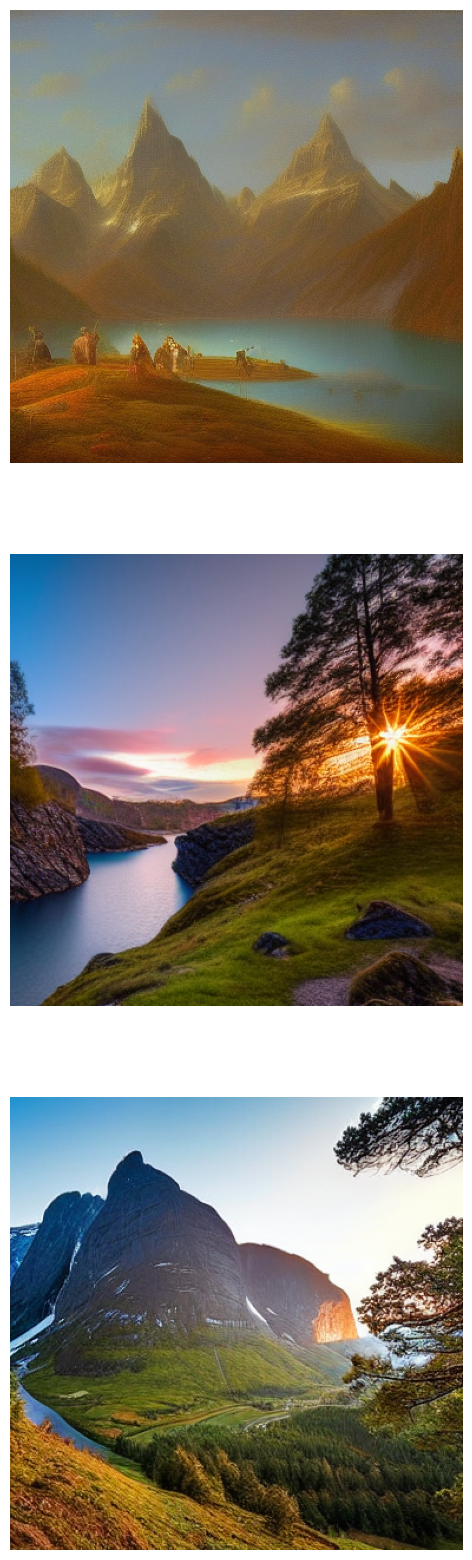

In [15]:
def plot_images(all_images):
    plt.figure(figsize=(20, 20))
    for i,row in enumerate(all_images):
        for j, img in enumerate(row):
            ax = plt.subplot(len(all_images), len(row), len(row)*i + j + 1)
            plt.imshow(img)
            plt.axis("off")


plot_images(all_images)